# **Zadanie 18.4**

### **Zaimplementowanie sieci neuronowej na używanym wcześniej zestawie Fashion-Mnist tak, aby uzyskać wynik na danych testowych rzędu accuracy > 0.94 (albo jak najbardziej zbliżony), używając poniższego podziału:**

`X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)`

### Importowanie bibliotek

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Wczytywanie i przygotowanie danych

In [2]:
# Pobranie zestawu Fashion-MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizacja wartości pikseli (0-255 -> 0-1)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Konwersja typów
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    train_images,
    train_labels,
    test_size=0.1,
    random_state=10,
    stratify=train_labels
)

# Dodanie wymiaru kanału (28,28) -> (28,28,1) dla warstw konwolucyjnych
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Tworzenie zbioru tensorflow Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(64)

### Definiowanie modelu CNN

In [3]:
# Wejście do modelu
input_layer = tf.keras.Input(shape=X_train.shape[1:])

# Blok konwolucyjny 1
conv1 = layers.Conv2D(32, (3, 3), padding="same")(input_layer)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.ReLU()(conv1)
conv1 = layers.Conv2D(32, (3, 3), padding="same")(conv1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.ReLU()(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
drop1 = layers.Dropout(0.25)(pool1)

# Blok konwolucyjny 2
conv2 = layers.Conv2D(64, (3, 3), padding="same")(drop1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.ReLU()(conv2)
conv2 = layers.Conv2D(64, (3, 3), padding="same")(conv2)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.ReLU()(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
drop2 = layers.Dropout(0.25)(pool2)

# Spłaszczenie
flatten = layers.Flatten()(drop2)

# Warstwa gęsta (Dense)
hidden_1 = layers.Dense(128, activation="relu")(flatten)

# **Residual connection - Concatenate Flatten + Hidden Layer**
concat_layer = layers.Concatenate()([flatten, hidden_1])

# Warstwa wyjściowa
output_layer = layers.Dense(10, activation="softmax")(concat_layer)

# Stworzenie modelu
model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# Kompilacja modelu
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Podsumowanie architektury
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 32)   0           ['batch_normalization[0][0]']

### Callbacki: Dynamiczny Learning Rate + Early Stopping

In [4]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.0001, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

### Trenowanie modelu

In [5]:
history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/30
844/844 [==============================] - 49s 55ms/step - loss: 0.5456 - accuracy: 0.8125 - val_loss: 0.3545 - val_accuracy: 0.8770 - lr: 5.0000e-04
Epoch 2/30
844/844 [==============================] - 56s 66ms/step - loss: 0.3348 - accuracy: 0.8815 - val_loss: 0.2762 - val_accuracy: 0.9042 - lr: 5.0000e-04
Epoch 3/30
844/844 [==============================] - 70s 83ms/step - loss: 0.2800 - accuracy: 0.9006 - val_loss: 0.2255 - val_accuracy: 0.9187 - lr: 5.0000e-04
Epoch 4/30
844/844 [==============================] - 47s 56ms/step - loss: 0.2501 - accuracy: 0.9097 - val_loss: 0.2240 - val_accuracy: 0.9182 - lr: 5.0000e-04
Epoch 5/30
844/844 [==============================] - 47s 56ms/step - loss: 0.2259 - accuracy: 0.9181 - val_loss: 0.2081 - val_accuracy: 0.9222 - lr: 5.0000e-04
Epoch 6/30
844/844 [==============================] - 48s 57ms/step - loss: 0.2096 - accuracy: 0.9238 - val_loss: 0.2044 - val_accuracy: 0.9250 - lr: 5.0000e-04
Epoch 7/30
844/844 [==============

### Ewaluacja modelu

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🔍 Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

188/188 [==============================] - 2s 13ms/step - loss: 0.1663 - accuracy: 0.9452

🔍 Test Accuracy: 0.9452
📉 Test Loss: 0.1663


### Wizualizacja Accuracy i Loss

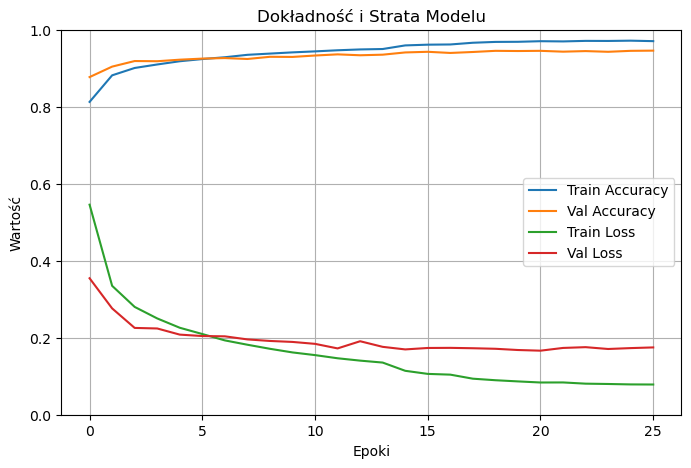

In [7]:
# Wykres dokładności i straty
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Dokładność i Strata Modelu")
plt.xlabel("Epoki")
plt.ylabel("Wartość")
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()

### Przykładowa predykcja i wizualizacja wyniku

1/1 [==============================] - 0s 250ms/step


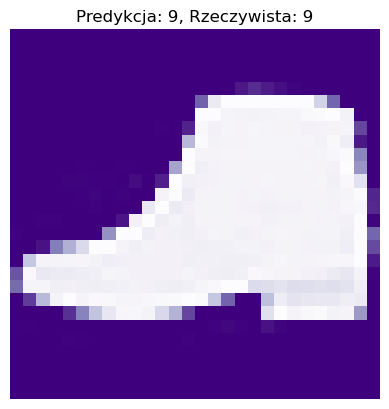

In [8]:
import random

# Losowy indeks obrazu testowego
idx = random.randint(0, len(X_test) - 1)

# Predykcja modelu
y_pred = model.predict(np.expand_dims(X_test[idx], axis=0))
predicted_label = np.argmax(y_pred)

# Rzeczywista etykieta
actual_label = y_test[idx]

# Wizualizacja obrazu
plt.imshow(X_test[idx].reshape(28, 28), cmap="Purples_r")
plt.title(f"Predykcja: {predicted_label}, Rzeczywista: {actual_label}")
plt.axis("off")
plt.show()

### **Zapisanie i dostarczenie modelu oraz napisanie interfejsu, który przyjmuje wartość wejściową oraz zwraca wartość przewidzianą przez nasz model wraz z wyrysowanym obrazem wejściowym (aby można było zweryfikować wizualnie, czy działa).**


### Zapis

In [9]:
# Zapisanie modelu w formacie .h5
model.save("fashion_mnist_model.h5")

### Odczyt

In [10]:
# Wczytanie modelu
from tensorflow.keras.models import load_model

model = load_model("fashion_mnist_model.h5")

# Sprawdzenie struktury modelu
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 32)   0           ['batch_normalization[0][0]']

### Interfejs do testów

1/1 [==============================] - 0s 171ms/step


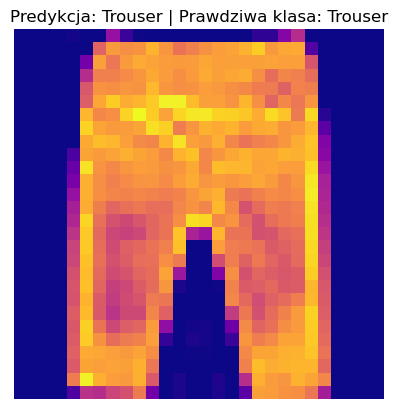

In [11]:
# Wybór konkretnego indeksu przez użytkownika
idx = int(input(f"Wpisz indeks obrazka (0 - {len(X_test)-1}): "))
img = X_test[idx]

# Predykcja klasy
img_reshaped = np.expand_dims(img, axis=0)  # Dodaj wymiar batcha
predictions = model.predict(img_reshaped)
predicted_class = np.argmax(predictions)

# Rzeczywista etykieta
actual_class = y_test[idx]

# Mapowanie etykiet na nazwy ubrań (dla lepszej czytelności)
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Wyświetlenie obrazka z predykcją
plt.imshow(img.reshape(28, 28), cmap="plasma")
plt.title(f"Predykcja: {class_labels[predicted_class]} | Prawdziwa klasa: {class_labels[actual_class]}")
plt.axis("off")
plt.show()

### **Podbiciewyniku do około 0.97 poprzez użycie technik augumentacji**

In [12]:
import albumentations as A

In [13]:
# Zdefiniowanie augmentacji
augmenter = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, border_mode=0, p=0.8),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=4, max_width=4, fill_value=0, p=0.3),
])

In [14]:
def augment_image(image):
    image = (image * 255).astype(np.uint8)
    
    augmented = augmenter(image=image)
    aug_image = augmented['image']
   
    aug_image = aug_image.astype(np.float32) / 255.0
    
    return aug_image

In [15]:
def augment_in_dataset(image, label):
    aug_img = tf.numpy_function(
        func=augment_image,
        inp=[image],
        Tout=tf.float32
    )

    aug_img.set_shape((28, 28, 1))  

    return aug_img, tf.cast(label, tf.int32)

In [16]:
train_ds_aug = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds_aug = train_ds_aug.shuffle(1000) \
                           .map(augment_in_dataset, num_parallel_calls=tf.data.AUTOTUNE) \
                           .batch(64) \
                           .prefetch(tf.data.AUTOTUNE)

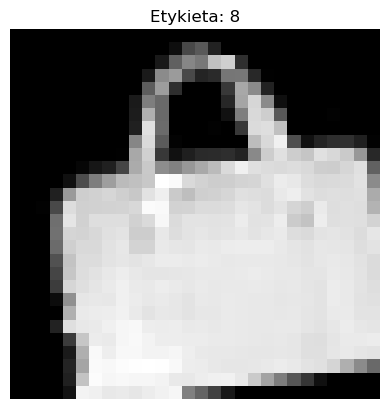

Przykładowy obrazek shape: (28, 28, 1), dtype: <dtype: 'float32'>, min: 0.0, max: 0.9058823585510254
Przykładowa etykieta: 8, dtype: <dtype: 'int32'>


In [17]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_ds_aug))
sample_image, sample_label = sample_batch[0][0], sample_batch[1][0]

plt.imshow(sample_image.numpy().squeeze(), cmap="gray")
plt.title(f"Etykieta: {sample_label.numpy()}")
plt.axis("off")
plt.show()

print(f"Przykładowy obrazek shape: {sample_image.shape}, dtype: {sample_image.dtype}, min: {sample_image.numpy().min()}, max: {sample_image.numpy().max()}")
print(f"Przykładowa etykieta: {sample_label.numpy()}, dtype: {sample_label.dtype}")


In [21]:
aug_model = load_model("fashion_mnist_model.h5")

aug_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

aug_callbacks_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True, verbose=1)
]

aug_model.fit(
    train_ds_aug,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/100
844/844 [==============================] - 65s 74ms/step - loss: 0.3247 - accuracy: 0.8865 - val_loss: 0.2017 - val_accuracy: 0.9247 - lr: 5.0000e-04
Epoch 2/100
844/844 [==============================] - 76s 90ms/step - loss: 0.2688 - accuracy: 0.9040 - val_loss: 0.2192 - val_accuracy: 0.9225 - lr: 5.0000e-04
Epoch 3/100
844/844 [==============================] - 72s 85ms/step - loss: 0.2606 - accuracy: 0.9048 - val_loss: 0.1899 - val_accuracy: 0.9315 - lr: 5.0000e-04
Epoch 4/100
844/844 [==============================] - 70s 83ms/step - loss: 0.2523 - accuracy: 0.9095 - val_loss: 0.1886 - val_accuracy: 0.9317 - lr: 5.0000e-04
Epoch 5/100
844/844 [==============================] - 74s 87ms/step - loss: 0.2433 - accuracy: 0.9121 - val_loss: 0.1842 - val_accuracy: 0.9295 - lr: 5.0000e-04
Epoch 6/100
844/844 [==============================] - 72s 86ms/step - loss: 0.2404 - accuracy: 0.9137 - val_loss: 0.1924 - val_accuracy: 0.9335 - lr: 5.0000e-04
Epoch 7/100
844/844 [=======

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🔍 Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

188/188 [==============================] - 5s 23ms/step - loss: 0.1663 - accuracy: 0.9452

🔍 Test Accuracy: 0.9452
📉 Test Loss: 0.1663


In [20]:
test_loss, test_accuracy = aug_model.evaluate(X_test, y_test, verbose=1)
print(f"\n🔍 Aug Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Aug Test Loss: {test_loss:.4f}")

188/188 [==============================] - 3s 15ms/step - loss: 0.1642 - accuracy: 0.9413

🔍 Aug Test Accuracy: 0.9413
📉 Aug Test Loss: 0.1642
